<a href="https://colab.research.google.com/github/sv650s/sb-capstone/blob/master/2019-07-22-GRU_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRUPrototype

Modeling this notebook after the following:

https://nbviewer.jupyter.org/github/dipanjanS/nlp_workshop_dhs18/blob/master/Unit%2012%20-%20Project%209%20-%20Sentiment%20Analysis%20-%20Supervised%20Learning/12B%20-%20Project%2011%20-%20Sentiment%20Analysis%20-%20Advanced%20Deep%20Learning%20-%20CNNs.ipynb


Making the following changes:

* last layer is a 5 node layer with softmax activation function since we are doing a 5 class classification
* Changing the loss function from binary_crossentropy to categorical_crossentropy since we are doing multi-class classification
* running fit with 50 epochs with early stopping with patience of 2
* also this notebook runs the CNN model twice - once with embedding of 32 (original), one with embedding of 300. At the end of the notebook, it prints a table to compare the two

In [24]:
from google.colab import drive
import sys
drive.mount('/content/drive')
# add this to sys patch so we can import utility functions
sys.path.append('drive/My Drive/Springboard/capstone')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GRU, SpatialDropout1D, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pickle
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns
import matplotlib.pyplot as plt


# custom utility functions
import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku


sns.set()


In [0]:
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-preprocessed-110k.csv"
FEATURE_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"




In [27]:
import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
df = pd.read_csv(f"{DATA_FILE}")

In [0]:
rating = df[FEATURE_COLUMN]
reviews = df[REVIEW_COLUMN]

## Preprocessing

In [30]:
# one hot encode ratings
# print(rating.shape)
# print(type(rating))
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()
# y[:3]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)

In [0]:
train_sequences = t.texts_to_sequences(reviews_train)

In [0]:
test_sequences = t.texts_to_sequences(reviews_test)

In [35]:
print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=40788
Number of Documents=84032


### Sequence Normalization

Figure out max length of review and pad the rest so they are all the same length

In [36]:
df["review_length"] = df.review_body.apply(lambda x: len(x.split()))
df.review_length.max()

2864

In [37]:
df.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes,review_length
count,1.120430e+05,1.120430e+05,112043.000000,112043.000000,112043.000000,112043.000000
mean,2.547598e+07,4.994998e+08,3.889078,0.912435,1.189704,26.322965
std,1.582173e+07,2.879968e+08,1.463196,10.304687,11.167197,47.248166
min,1.014100e+04,1.365700e+04,1.000000,0.000000,0.000000,1.000000
25%,1.231110e+07,2.493906e+08,3.000000,0.000000,0.000000,8.000000
50%,2.344848e+07,4.990693e+08,5.000000,0.000000,0.000000,15.000000
75%,4.040851e+07,7.481358e+08,5.000000,0.000000,1.000000,29.000000
max,5.309655e+07,9.999930e+08,5.000000,1447.000000,1524.000000,2864.000000


Looks like 99% of our reviews have 186 words or less. If we keep our sequence length to around 64 words, this should allow us to keep most of our content

NOTE: no need to do encoding for our star_ratings since this is already in a number format

In [38]:
MAX_SEQUENCE_LENGTH = int(df.review_length.quantile([0.99]).values[0])
MAX_SEQUENCE_LENGTH

186

In [0]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
# X_train[:1]

In [0]:
# this is our star rating column
# rating.head()

# Building Our GRU Model

In [0]:
MODEL_NAME = "GRU_1layer"
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128
VOCAB_SIZE = len(t.word_counts)+1
GRU_DIM = 250 # total GRU units



In [0]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(units=GRU_DIM, activation='tanh', use_bias=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(250, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [44]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 186, 300)          12236700  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 186, 300)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500)               826500    
_________________________________________________________________
dense_3 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1255      
Total params: 13,189,705
Trainable params: 13,189,705
Non-trainable params: 0
_________________________________________________________________
None


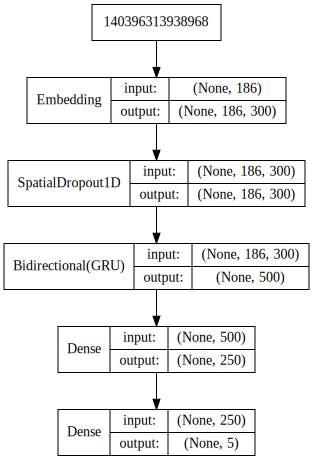

In [45]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [46]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
network_history = model.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop])

W0725 03:34:52.406214 140398026368896 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 67225 samples, validate on 16807 samples
Epoch 1/50
67225/67225 [==============================] - 322s 5ms/step - loss: 0.9448 - acc: 0.6409 - val_loss: 0.8647 - val_acc: 0.6628
Epoch 2/50
67225/67225 [==============================] - 309s 5ms/step - loss: 0.7861 - acc: 0.6927 - val_loss: 0.8464 - val_acc: 0.6711
Epoch 3/50
67225/67225 [==============================] - 307s 5ms/step - loss: 0.6976 - acc: 0.7283 - val_loss: 0.8748 - val_acc: 0.6697
Epoch 4/50
67225/67225 [==============================] - 308s 5ms/step - loss: 0.6126 - acc: 0.7676 - val_loss: 0.9284 - val_acc: 0.6668
Epoch 00004: early stopping


In [47]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))


28011/28011 [==============================] - 175s 6ms/step
Accuracy: 66.88%


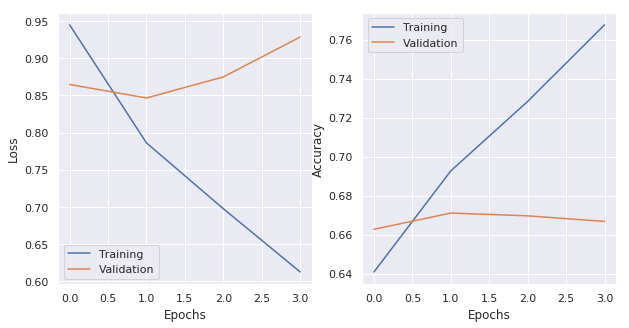

In [50]:
pu.plot_network_history(network_history)

In [0]:
y_predict = model.predict(X_test)

### unencode our y's so we can calculate statistics to evalue our models

In [0]:
# use our utility function to unencode y so we can pass these to sklearn
y_predict_unencoded = ku.unencode(y_predict)
y_test_unencoded = ku.unencode(y_test)


In [55]:
confusion_matrix(y_test_unencoded, y_predict_unencoded)

array([[ 3110,   206,   255,    95,   302],
       [  836,   194,   376,   191,   274],
       [  456,   197,   624,   574,   680],
       [  158,    67,   365,  1388,  2774],
       [  225,    42,   180,  1023, 13419]])

In [56]:
print(classification_report(y_test_unencoded, y_predict_unencoded))

              precision    recall  f1-score   support

           1       0.65      0.78      0.71      3968
           2       0.27      0.10      0.15      1871
           3       0.35      0.25      0.29      2531
           4       0.42      0.29      0.35      4752
           5       0.77      0.90      0.83     14889

    accuracy                           0.67     28011
   macro avg       0.49      0.47      0.47     28011
weighted avg       0.62      0.67      0.64     28011



In [0]:
roc_auc, fpr, tpr = ku.calculate_roc_auc(y_test, y_predict)

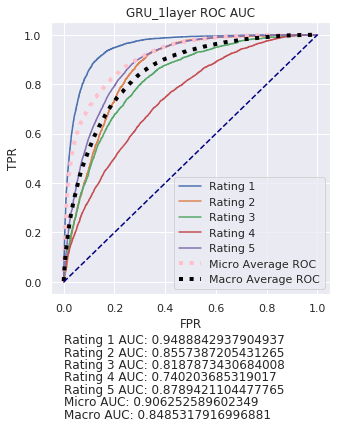

In [58]:
fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(MODEL_NAME, roc_auc, fpr, tpr)

### Save off various files

In [0]:
directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
DESCRIPTION = f"{INBASENAME}-{MODEL_NAME}-{MAX_SEQUENCE_LENGTH}-{FEATURE_COLUMN}"
MODEL_FILE = f"{DRIVE_DIR}/models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}.h5"
NETWORK_HISTORY_FILE = f'{DRIVE_DIR}/models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-history.pkl'
REPORT_FILE = f"{DRIVE_DIR}/reports/{datetime.now().strftime(DATE_FORMAT)}-DNN_protype-report.csv"
TOKENIZER_FILE = f'{DRIVE_DIR}/models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-tokenizer.pkl'


In [0]:
model.save(MODEL_FILE)

In [0]:
pickle.dump(network_history, open(NETWORK_HISTORY_FILE, "wb"))
pickle.dump(t, open(TOKENIZER_FILE, "wb"))

In [0]:
# saving off report in the same format as other report just in case we want to compare for later
flattened = {}
flattened = du.add_dict_to_dict(flattened, classification_report(y_test_unencoded, y_predict_unencoded, output_dict=True))
flattened = du.add_dict_to_dict(flattened, roc_auc)
flattened["tpr"] = tpr
flattened["fpr"] = fpr
flattened["loss"] = scores[0]
flattened["accuracy"] = scores[1]
flattened["confusion_matrix"] = confusion_matrix(y_test_unencoded, y_predict_unencoded)
flattened["description"] = DESCRIPTION
flattened["file"] = DATA_FILE
flattened["network_history_file"] = NETWORK_HISTORY_FILE
flattened["tokenizer_file"] = TOKENIZER_FILE
flattened["max_sequence_length"] = MAX_SEQUENCE_LENGTH
flattened["embedding"] = EMBED_SIZE
flattened["model_file"] = MODEL_FILE
flattened["model_name"] = MODEL_NAME
flattened["test_examples"] = X_test.shape[0]
flattened["test_features"] = X_test.shape[1]
flattened["train_examples"] = X_train.shape[0]
flattened["train_features"] = X_train.shape[1]
flattened["status"] = "success"
flattened["status_date"] = datetime.now().strftime(TIME_FORMAT)


In [65]:
# check to see if report file exisits, if so load it and append
print(f'Loading {REPORT_FILE}')
exists = os.path.isfile(REPORT_FILE)
if exists:
    report_df = pd.read_csv(REPORT_FILE)
else:
    report_df = pd.DataFrame()
    
report_df = report_df.append(flattened, ignore_index=True)
report_df.head(20)

Loading drive/My Drive/Springboard/capstone/reports/2019-07-25-DNN_protype-report.csv


,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,3_recall,3_support,4_f1-score,4_precision,4_recall,4_support,5_f1-score,5_precision,5_recall,5_support,accuracy,auc_1,auc_2,auc_3,auc_4,auc_5,auc_macro,auc_micro,confusion_matrix,description,embedding,file,fpr,loss,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,max_sequence_length,model_file,model_name,network_history_file,status,status_date,test_examples,test_features,tokenizer_file,tpr,train_examples,train_features,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support
0,0.710614,0.649948,0.78377,3968.0,0.150563,0.274788,0.103688,1871.0,0.288155,0.346667,0.246543,2531.0,0.346005,0.424335,0.292088,4752.0,0.829921,0.769041,0.901269,14889.0,0.668844,0.948884,0.855739,0.818787,0.740204,0.878942,0.848532,0.906253,"[[3110, 206, 255, 95, 302], [836, 194, 376, 19...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,drive/My Drive/Springboard/capstone/data/amazo...,"{0: [0.0, 0.0, 0.0, 4.159214740257039e-05, 4.1...",0.919215,0.465052,0.492956,0.465472,28011.0,186.0,drive/My Drive/Springboard/capstone/models/201...,GRU_1layer,drive/My Drive/Springboard/capstone/models/201...,success,2019-07-25 04:08:14,28011.0,186.0,drive/My Drive/Springboard/capstone/models/201...,"{0: [0.0, 0.00025201612903225806, 0.0108366935...",84032.0,186.0,0.636595,0.622514,0.668844,28011.0


In [0]:
report_df.to_csv(REPORT_FILE, index=False)